In this notebook, we will build a neural net capable of discerning real banknotes from forged ones based some of their statistical properties

We first import the necessary modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score


We load the dataset as a pandas dictionary and extract the features and target as seperate datasets

In [2]:
data=pd.read_csv("data.csv")
features=data.drop('forge', axis=1)
labels=data['forge']

# Preprocessing and Viewing the Data


Each element of the dataset contains 4 features wich describe the statistical properties of a banknote after scanning it and applying a wavelet transform. We begin by exhibiting some descriptive statistical properties of the dataset:

In [3]:
features.describe()

,var,skew,curt,ent
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


To visualize these descriptive statistics, we display the boxplot:

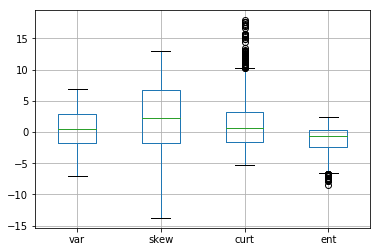

In [4]:
features.boxplot()
plt.show()

It is clear that datapoints with a curtosis exceeding 11 or entropy below -7 are outliers. We compute how many there are:

In [5]:
print(features[(features['curt']>11)|(features['ent']<-7)].shape[0])

65


Since there are only 65 outliers, we choose to remove them. We then split the data into features and labels again

In [6]:
##new_data=data[(features['curt'<11) | (features['ent']>-7)]
new_data=data
new_features=new_data.drop(['forge'], axis=1)
new_labels=new_data['forge']

We first compute the various correlations between the features, as correlated features could result in overfitting:

           var      skew      curt       ent
var   1.000000  0.264026 -0.380850  0.276817
skew  0.264026  1.000000 -0.786895 -0.526321
curt -0.380850 -0.786895  1.000000  0.318841
ent   0.276817 -0.526321  0.318841  1.000000


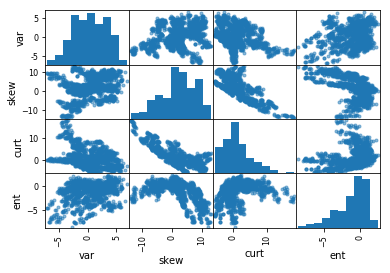

In [7]:
from pandas.tools.plotting import scatter_matrix

correlation=new_features.corr(method='pearson')
print(correlation)
scatter_matrix(new_features)
plt.show()

It seems there is a high correlation between skewness and curtosis, which is to be expected geometrically. The other features seem to be uncorrelated

to visualize the features, we first first define a function that reduces the dimension space using a principal component analysis:

In [58]:
def reduce(features,d):
    pca=PCA(n_components=d)
    pca.fit(features)
    print(pca.explained_variance_ratio_)
    reduced_data=pca.transform(features)
    return reduced_data

We then use the above function to compute how the data can be separated linearly in in dimension 4,3 and 2

In [59]:
def lin_sep_acc(features,labels,m):
    d=features.shape[1]
    for i in range(m,d+1):
        reduced_features=reduce(features,i) ##the variance will be printed
        clf=SVC(random_state=30)
        clf.fit(reduced_features,labels)
        predicted_labels=clf.predict(reduced_features)
        a=accuracy_score(predicted_labels,labels)
        print("after reducing to %i dimensions, the accuracy is %a" %(i,a) )

In [34]:
lin_sep_acc(features,labels,2)

[ 0.76132409  0.1419049 ]
after reducing to 2 dimensions, the accuracy is 0.59453352769679313
[ 0.76132409  0.1419049   0.06701767]
after reducing to 3 dimensions, the accuracy is 0.78114674441205056
[ 0.76132409  0.1419049   0.06701767  0.02975334]
after reducing to 4 dimensions, the accuracy is 0.8125


the data is not linearly separably, as a sanity check, we check to see if it can be separated by a cubic instead

In [38]:
def poly_sep_acc(features,labels,m):
    d=features.shape[1]
    for i in range(m,d+1):
        reduced_features=reduce(features,i) ##the variance will be printed
        clf=SVC(kernel='poly', degree=3, random_state=30)
        clf.fit(reduced_features,labels)
        predicted_labels=clf.predict(reduced_features)
        a=accuracy_score(predicted_labels,labels)
        print("after reducing to %i dimensions, the accuracy is %a" %(i,a) )

In [39]:
poly_sep_acc(features,labels,2)

[ 0.76132409  0.1419049 ]
after reducing to 2 dimensions, the accuracy is 0.41523323615160351
[ 0.76132409  0.1419049   0.06701767]
after reducing to 3 dimensions, the accuracy is 0.78114674441205056
[ 0.76132409  0.1419049   0.06701767  0.02975334]
after reducing to 4 dimensions, the accuracy is 0.8125


The results are rather comparable, impying that a there is no clear decision  boundary

we next display the reduced data:

[ 0.76132409  0.1419049   0.06701767]


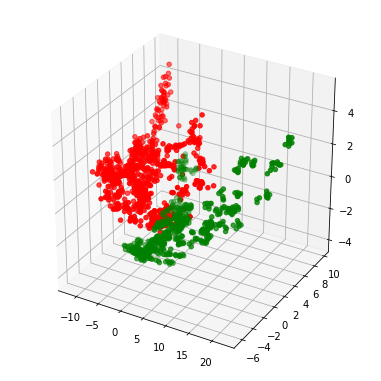

[ 0.76132409  0.1419049 ]


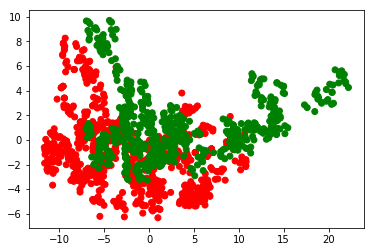

In [40]:
#plot the 3d data:
fig3D = plt.figure(figsize=(5,5))
ax = Axes3D(fig3D)

threed_reduced_features=reduce(new_features,3)

x=threed_reduced_features[:,0]
y=threed_reduced_features[:,1]
z=threed_reduced_features[:,2]

colors = ['red','green']
ax.scatter(x,y,z, c=new_labels, cmap=ListedColormap(colors))
plt.show()


#plot the 2d data
twod_reduced_features=reduce(new_features,2)

x=twod_reduced_features[:,0]
y=twod_reduced_features[:,1]
colors = ['red','green']
plt.scatter(x,y, c=new_labels, cmap=ListedColormap(colors))
plt.show()



# Preprocessing and Viewing the Data


we begin by splitting the data into training and testing set:

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(new_features, new_labels,test_size=0.45, random_state=20)

Next, we import the necessary functionality from keras:

In [13]:
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint  
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers

Using TensorFlow backend.


We reshape the training and testing data to make it compatible with keras

In [41]:
##translate  the features from dataframe to numpy array, and convert the labels to 2-tuples

x_train=X_train.as_matrix()
x_test=X_test.as_matrix()
y_train = np_utils.to_categorical(Y_train, 2)
y_test = np_utils.to_categorical(Y_test, 2)


Next, to view the results later on, we define a function that plots the learning curves for both the loss and accuracy. To this end, we use the predefined variables in the histroy function built into keras

In [42]:
def learning_curves(model):
    #plot the learning curve for the accuracy
        #plot the accuracy on the training set
        plt.plot(model.history['acc'])
        #plot the accuracy on the testing set
        plt.plot(model.history['val_acc'])
        #describe the labels
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    # plot the learning curve for the loss
        #plot the loss on the training set
        plt.plot(model.history['loss'])
        #plot the loss on the testing set
        plt.plot(model.history['val_loss'])
        #describe the labels
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

Next, we define a function that will compile and fit a neural network according to a prescribed model, optimizer and amount of epochs.  We record the data in a helper file

In [43]:
def comp_fit(model,sgd,epochs):
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', verbose=2, save_best_only=True)
    history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=10,callbacks=[checkpointer],  verbose=1)
    return history

As a first simple model, we implement logistic regression using the standard rmsprop optimizer

Train on 754 samples, validate on 618 samples
Epoch 1/300
754/754 [==============================] - 0s - loss: 1.4565 - acc: 0.7533 - val_loss: 1.3449 - val_acc: 0.7864
Epoch 2/300
754/754 [==============================] - 0s - loss: 1.3412 - acc: 0.7586 - val_loss: 1.2397 - val_acc: 0.7945
Epoch 3/300
754/754 [==============================] - 0s - loss: 1.2479 - acc: 0.7666 - val_loss: 1.1091 - val_acc: 0.7994
Epoch 4/300
754/754 [==============================] - 0s - loss: 1.1182 - acc: 0.7732 - val_loss: 1.0678 - val_acc: 0.8058
Epoch 5/300
754/754 [==============================] - 0s - loss: 1.0662 - acc: 0.7785 - val_loss: 0.9921 - val_acc: 0.8139
Epoch 6/300
754/754 [==============================] - 0s - loss: 1.0002 - acc: 0.7865 - val_loss: 0.9416 - val_acc: 0.8252
Epoch 7/300
754/754 [==============================] - 0s - loss: 0.9621 - acc: 0.7984 - val_loss: 0.8946 - val_acc: 0.8398
Epoch 8/300
754/754 [==============================] - 0s - loss: 0.9052 - acc: 0.8143

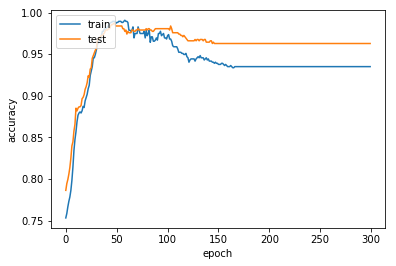

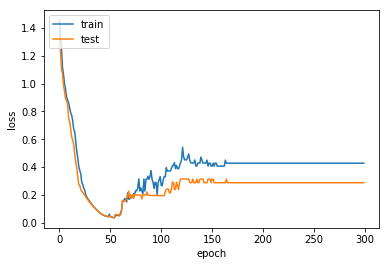

In [18]:
##build a logistical regression first
logmodel=Sequential()
logmodel.add(Dense(2,input_dim=4,activation='sigmoid'))
history=comp_fit(logmodel,'rmsprop',300)
learning_curves(history)

The model seems to fit the data rather nicely, the cost is rather high however.  To improve the accuracy, we change the optimizer to an Adam optimizer

Train on 754 samples, validate on 618 samples
Epoch 1/300
754/754 [==============================] - 0s - loss: 2.7384 - acc: 0.6220 - val_loss: 2.6424 - val_acc: 0.6375
Epoch 2/300
754/754 [==============================] - 0s - loss: 2.7203 - acc: 0.6340 - val_loss: 2.5824 - val_acc: 0.6505
Epoch 3/300
754/754 [==============================] - 0s - loss: 2.5728 - acc: 0.6499 - val_loss: 2.5074 - val_acc: 0.6586
Epoch 4/300
754/754 [==============================] - 0s - loss: 2.4893 - acc: 0.6645 - val_loss: 2.4341 - val_acc: 0.6650
Epoch 5/300
754/754 [==============================] - 0s - loss: 2.3325 - acc: 0.6751 - val_loss: 2.3038 - val_acc: 0.6828
Epoch 6/300
754/754 [==============================] - 0s - loss: 2.2351 - acc: 0.6870 - val_loss: 2.2466 - val_acc: 0.6812
Epoch 7/300
754/754 [==============================] - 0s - loss: 2.1620 - acc: 0.6963 - val_loss: 2.1862 - val_acc: 0.6845
Epoch 8/300
754/754 [==============================] - 0s - loss: 2.1327 - acc: 0.7016

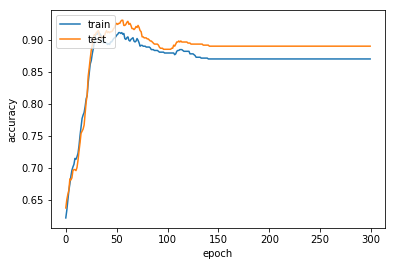

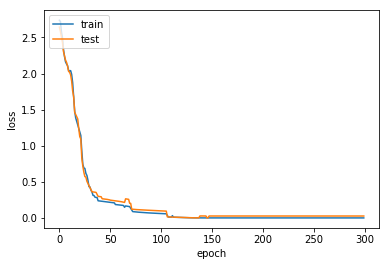

In [19]:
log_model=Sequential()
log_model.add(Dense(2,input_dim=4,activation='sigmoid'))
history=comp_fit(log_model,'Adam',300)
learning_curves(history)

as we can see, the accuracy has not changed, but the cost function decreased significantly. To further improve the network, we include a hidden layer

Train on 754 samples, validate on 618 samples
Epoch 1/300
754/754 [==============================] - 0s - loss: 0.6735 - acc: 0.4735 - val_loss: 0.6616 - val_acc: 0.5243
Epoch 2/300
754/754 [==============================] - 0s - loss: 0.6481 - acc: 0.6114 - val_loss: 0.6365 - val_acc: 0.7282
Epoch 3/300
754/754 [==============================] - 0s - loss: 0.6229 - acc: 0.7944 - val_loss: 0.6105 - val_acc: 0.8706
Epoch 4/300
754/754 [==============================] - 0s - loss: 0.5961 - acc: 0.8793 - val_loss: 0.5819 - val_acc: 0.9110
Epoch 5/300
754/754 [==============================] - 0s - loss: 0.5664 - acc: 0.9045 - val_loss: 0.5496 - val_acc: 0.9304
Epoch 6/300
754/754 [==============================] - 0s - loss: 0.5319 - acc: 0.9297 - val_loss: 0.5111 - val_acc: 0.9466
Epoch 7/300
754/754 [==============================] - 0s - loss: 0.4901 - acc: 0.9443 - val_loss: 0.4630 - val_acc: 0.9531
Epoch 8/300
754/754 [==============================] - 0s - loss: 0.4361 - acc: 0.9469

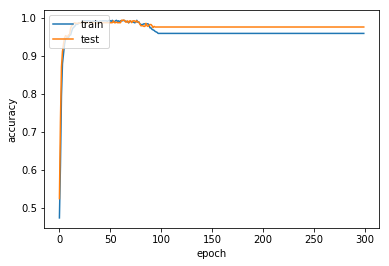

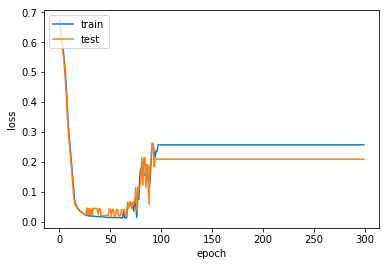

In [23]:
log_model_hl=Sequential()
log_model_hl.add(Dense(4,input_dim=4,activation='sigmoid'))
log_model_hl.add(Dense(2,input_dim=4,activation='sigmoid'))
history=comp_fit(log_model_hl,'Adam',300)
learning_curves(history)

The accuracy has significantly improved. We finally include a dropout to see if this changes the accuracy further:

Train on 754 samples, validate on 618 samples
Epoch 1/300
754/754 [==============================] - 1s - loss: 0.7754 - acc: 0.4960 - val_loss: 0.6869 - val_acc: 0.5210
Epoch 2/300
754/754 [==============================] - 0s - loss: 0.7109 - acc: 0.5279 - val_loss: 0.6524 - val_acc: 0.5777
Epoch 3/300
754/754 [==============================] - 0s - loss: 0.6661 - acc: 0.5743 - val_loss: 0.6214 - val_acc: 0.6731
Epoch 4/300
754/754 [==============================] - 0s - loss: 0.6331 - acc: 0.5915 - val_loss: 0.5949 - val_acc: 0.7217
Epoch 5/300
754/754 [==============================] - 0s - loss: 0.6339 - acc: 0.6194 - val_loss: 0.5575 - val_acc: 0.8528
Epoch 6/300
754/754 [==============================] - 0s - loss: 0.5786 - acc: 0.6631 - val_loss: 0.5214 - val_acc: 0.9061
Epoch 7/300
754/754 [==============================] - 0s - loss: 0.5366 - acc: 0.7016 - val_loss: 0.4881 - val_acc: 0.9045
Epoch 8/300
754/754 [==============================] - 0s - loss: 0.5185 - acc: 0.6910

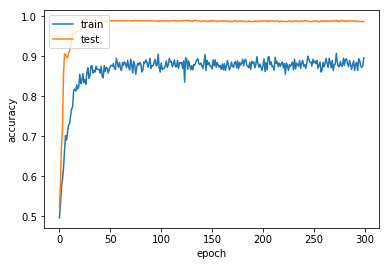

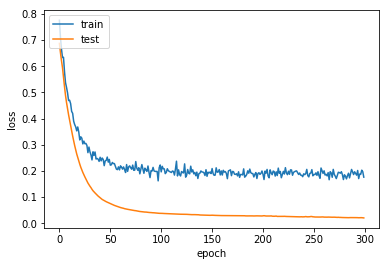

In [50]:
log_model_hl_dp=Sequential()
log_model_hl_dp.add(Dense(4,input_dim=4,activation= 'sigmoid'))
log_model_hl_dp.add(Dropout(0.5))
log_model_hl_dp.add(Dense(2,input_dim=4,activation='sigmoid'))
history=comp_fit(log_model_hl_dp,'Adam',300)
learning_curves(history)

Including Dropout results in an accuracy of $99\%$ on testing set

we finally create a function that predicts whether a banknote is real depending on the model and check it on both a real and forged banknote:

In [60]:
def classify(features):
    features=np.array([features])
    prediction=log_model_hl.predict(features)
    prediction=np.argmax(prediction[0])
    if prediction == 1:
        print('the banknote is forged')
    else:
        print('the banknote is real')

In [61]:
classify([3.621600,8.66610,-2.807300,-0.446990] )
classify([-1.747900, -5.82300,5.869900 ,1.212000])

the banknote is real
the banknote is forged
